### Data
Raster : Regular images
Vector : 

## Plot Sentinel Image

In [29]:
import rasterio
from rasterio.windows import Window
import os

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# RGB Normalization bands
def preprocess(band):
    # Step 1: Divide by 10,000
    band = band / 10000.0
    
    # Step 2: Clip to the range [0, 0.3]
    band = np.clip(band, 0, 3)
    
    return band

# Generic Normalization
def normalize_band(band, clip=False):
    if clip:
        band = preprocess(band)
    return (band - np.nanmin(band)) / (np.nanmax(band) - np.nanmin(band))

def load_data(image_arr):
    # Assuming `data` is your numpy array of shape (27, 600, 1000)
    # Extract the Blue, Green, and Red bands
    blue = image_arr[2]
    green = image_arr[3]
    red = image_arr[4]
    ndvi = image_arr[-1]  # Last band for NDVI

    red_normalized = normalize_band(red, 1) # .astype(np.uint8)
    green_normalized = normalize_band(green, 1) # .astype(np.uint8)
    blue_normalized = normalize_band(blue, 1) # .astype(np.uint8)
    ndvi_normalized = normalize_band(ndvi)

    # Stack the normalized bands to create an RGB image
    rgb_image = np.stack([red_normalized, green_normalized, blue_normalized], axis=-1)
    # rgb_image = np.stack([ blue_normalized, green_normalized, red_normalized ], axis=-1)

    return rgb_image, ndvi_normalized

## LOAD MERGED BEFORE AND AFTER

In [3]:
from rasterio.merge import merge
before_tif_1 = './rgb_image_satellite_dec3/NDVI_Before_Tillage_dec_3-0000000000-0000000000.tif'
before_tif_2 = './rgb_image_satellite_dec3/NDVI_Before_Tillage_dec_3-0000006400-0000000000.tif'
before_src_files = [rasterio.open(fp) for fp in [ before_tif_1, before_tif_2 ]]
before, before_merged_transform = merge(before_src_files)


after_tif_1 = './rgb_image_satellite_dec3/NDVI_After_Tillage_dec_3-0000000000-0000000000.tif'
after_tif_2 = './rgb_image_satellite_dec3/NDVI_After_Tillage_dec_3-0000006400-0000000000.tif'
after_src_files = [rasterio.open(fp) for fp in [ after_tif_1, after_tif_2 ]]
after, after_merged_transform = merge(after_src_files)

In [4]:
from rasterio.transform import array_bounds

In [5]:
height, width = before.shape[1:]
array_bounds(height, width, before_merged_transform)

(-97.07850730352956, 42.76052617631652, -96.80380248964582, 43.54798935437569)

In [6]:
#  ## Take a snippet for image
ROW_START = 1000
ROW_END = 7900
COL_START = 100
COL_END = 2800
before = before[: , ROW_START:ROW_END, COL_START:COL_END ]
after = after[ :, ROW_START:ROW_END, COL_START:COL_END ]

# LOAD ACTUAL RGB

In [7]:
# before_rgb_tif = './rgb_image_satellite_dec3/RGB_Before_Tillage_dec_3.tif'
before_rgb_tif = './rgb_image_satellite_dec3/RGB_Before_Tillage_latest.tif'

after_rgb_tif = './rgb_image_satellite_dec3/RGB_After_Tillage_latest.tif'


with rasterio.open(before_rgb_tif) as src:
    before_desc = src.descriptions
    before_rgb = src.read()

with rasterio.open(after_rgb_tif) as src:
    after_desc = src.descriptions
    after_rgb = src.read()

before_rgb = before_rgb[:, ROW_START:ROW_END, COL_START:COL_END]
after_rgb = after_rgb[:, ROW_START:ROW_END, COL_START:COL_END]

before_rgb = np.transpose(before_rgb/255, (1,2,0))
after_rgb = np.transpose(after_rgb/255, (1,2,0))
print("Before Shape : ", before_rgb.shape)
print("After Shape : ", after_rgb.shape)

Before Shape :  (6900, 2700, 3)
After Shape :  (6900, 2700, 3)


In [8]:
_, before_ndvi = load_data(before)
_, after_ndvi = load_data(after)

In [9]:
# before_rgb = before_rgb[ROW_START:ROW_END, COL_START:COL_END, :  ]
# after_rgb = after_rgb[ ROW_START:ROW_END, COL_START:COL_END, : ]

# before_ndvi = before_ndvi[ ROW_START:ROW_END, COL_START:COL_END ]
# after_ndvi = after_ndvi[ROW_START:ROW_END, COL_START:COL_END ]


In [10]:
nan_count = np.count_nonzero(np.isnan(after_rgb))
nan_count

0

In [11]:
before.shape, after.shape, before_rgb.shape, after_rgb.shape

((27, 6900, 2700), (27, 6900, 2700), (6900, 2700, 3), (6900, 2700, 3))

In [12]:
before_rgb[: , :500, :500].shape

(6900, 500, 3)

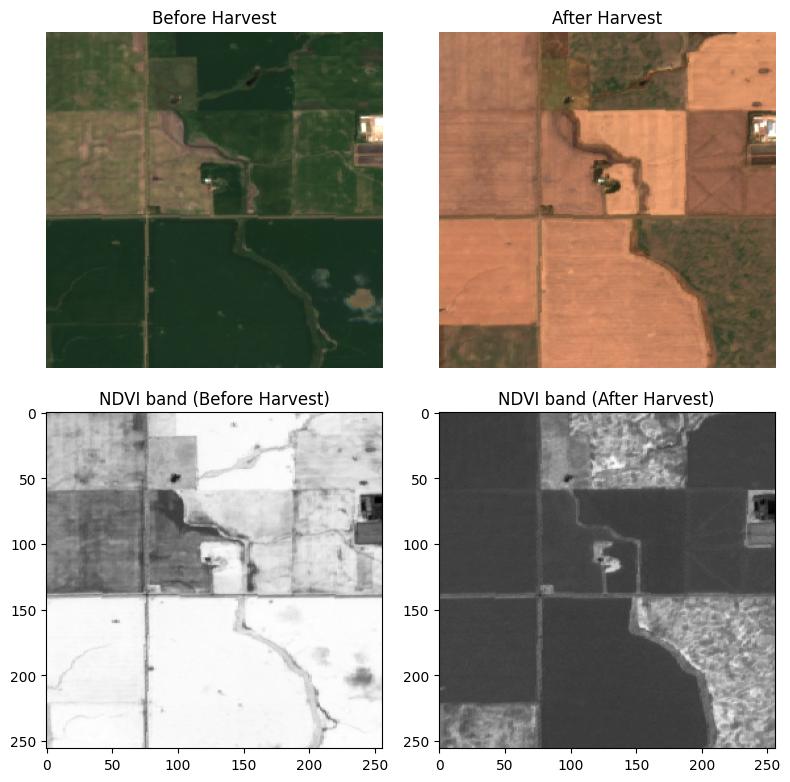

In [104]:
# plt.figure(figsize=(12, 6))  # Create a figure with a width and height
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Plot the "before" image
axes[0,0].imshow(before_rgb[ :256, :256, :])
axes[0,0].set_title("Before Harvest")
axes[0,0].axis('off')  # Turn off the axis

# Save just the portion _inside_ the second axis's boundaries
extent = axes[0,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig('ax2_figure.png', bbox_inches=extent)
# Pad the saved area by 10% in the x-direction and 20% in the y-direction
fig.savefig('ax2_figure_expanded.png', dpi=300, bbox_inches=extent.expanded(1.1, 1.2), pad_inches=0 )

# axes[0,0].savefig("high_quality_image1.png", dpi=300, bbox_inches='tight', pad_inches=0)

# Plot the "after" image
axes[0,1].imshow(after_rgb[:256, :256, :])
axes[0,1].set_title("After Harvest")
axes[0,1].axis('off')  # Turn off the axis

# Plot the "before" ndvi image
axes[1, 0].imshow(before_ndvi[:256, :256], cmap='gray')
axes[1, 0].set_title("NDVI band (Before Harvest)")

# Plot the "after" ndvi image
axes[1, 1].imshow(after_ndvi[:256, :256], cmap='gray')
axes[1, 1].set_title("NDVI band (After Harvest)")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [14]:
before_ndvi.shape, after_ndvi.shape

((6900, 2700), (6900, 2700))

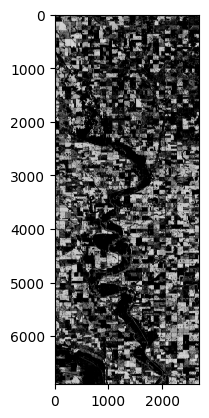

In [15]:
## Prepare Label. This shows cropland. 
# See how much change happened before and after ... 
change = before_ndvi - after_ndvi
# Only use change from before to After.
change[change<=0] = 0
change = ( change - change.min() ) / (change.max() - change.min())

plt.imshow(change, cmap='gray')
plt.savefig("high_quality_image1.png", dpi=300, bbox_inches='tight', pad_inches=0)

In [16]:
np.count_nonzero((np.isnan(change)))

0

In [17]:
before.shape, after.shape, change.shape

((27, 6900, 2700), (27, 6900, 2700), (6900, 2700))

In [18]:
# Define the tile size
TILE_SIZE = 256

In [79]:
# Assuming your original array is named `array` with shape (N, 1443, 1499)
_, H, W = before.shape

# Calculate the number of tiles that fit in each dimension
num_tiles_y = H // TILE_SIZE  # Number of tiles along the height
num_tiles_x = W // TILE_SIZE  # Number of tiles along the width

print(num_tiles_x, num_tiles_y)

# Initialize a list to store the tiles
tiles_before = []
tiles_after = []
tiles_changes = []

row_col_info = [] # To get back corresponding RGB images for plot from before_rgb, after_rgb
# Loop through the height and width to extract each tile
for i in range(num_tiles_y):
    for j in range(num_tiles_x):
        row_start, row_end = i * TILE_SIZE, (i+1) * TILE_SIZE
        col_start, col_end = j * TILE_SIZE, (j+1) * TILE_SIZE

        row_col_info.append( [row_start, row_end, col_start, col_end] )
        # Extract the tile
        tile_before = before[:, row_start:row_end, col_start:col_end ]
        tile_after = after[ :, row_start:row_end, col_start:col_end ]
        tile_change = change[ row_start:row_end, col_start:col_end ]
        tiles_before.append(tile_before)
        tiles_after.append(tile_after)
        tiles_changes.append(tile_change)

# Convert list of tiles to numpy array
tiles_before = np.array(tiles_before)
tiles_after = np.array(tiles_after)
tiles_changes = np.array(tiles_changes)

print(tiles_before.shape)  # Expected shape: (num_tiles_y * num_tiles_x, N, 256, 256)

tiles_all = np.concatenate( (tiles_before, tiles_after) , axis=0)
tiles_changes_all = np.concatenate( (tiles_changes, tiles_changes) , axis=0)
row_col_info_all = np.concatenate( ( row_col_info, row_col_info ), axis=0)


import pickle

indices_path = "data_indices.pkl"
if os.path.exists(indices_path):
    print("Loading INdices")
    with open( indices_path , 'rb') as f:
        indices = pickle.load(f)

else:
    print("Dumping Indices")
    with open( indices_path, 'wb') as f:
        indices = list(np.random.permutation(tiles_all.shape[0]))
        pickle.dump(indices, f)

row_col_info_all = np.array(row_col_info_all)[indices]
tiles_all = tiles_all[indices]
tiles_changes_all = tiles_changes_all[indices]

10 26
(260, 27, 256, 256)
Loading INdices


In [80]:
def per_channel_normalize(x):
    '''
    x : numpy array of shape (channel, height, width)
    ## USED TO NORMALIZE INPUT CHANNEL
    '''
    out = (x.T - x.min((1,2))) / (x.max((1,2)) - x.min((1,2)))
    return out.transpose(2,1,0)

/var/folders/5q/d5sngbr11bj5s27jzhrdww2r0000gn/T/ipykernel_64380/895092968.py:6: RuntimeWarning: invalid value encountered in divide
  out = (x.T - x.min((1,2))) / (x.max((1,2)) - x.min((1,2)))


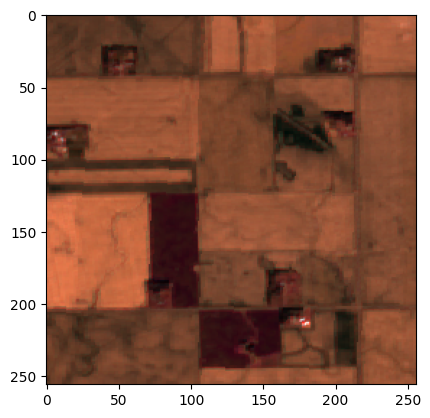

In [83]:
plt.imshow(
    per_channel_normalize( tiles_after[12] ) # shape is : c,h,w
    .transpose(1,2,0) # change to : h,w,c
    [ :, : , [4,3,2] ] ) # select specific channels

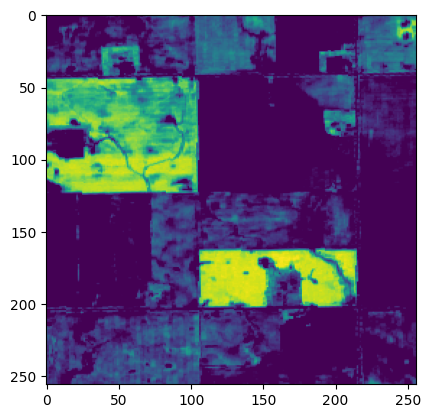

In [84]:
plt.imshow(tiles_changes[12] )

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

In [86]:
# device = torch.device('mps')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [87]:
device

device(type='mps')

In [226]:
CHANNELS_INDEXES = [4,3,2,7] ## channels to use in modeling
BATCH_SIZE = 16
NUM_CHANNELS = len(CHANNELS_INDEXES)

In [227]:
CHANNELS_INDEXES

[4, 3, 2, 7]

In [228]:
class CropLandDataset(Dataset):
    def __init__(self, X_images_all, Y_masks, position_info, channels_idx=[], transform=None):
        self.X_combined = X_images_all
        self.Y_combined = Y_masks
        self.transform = transform
        self.position_info = position_info

        if not channels_idx:
            self.channels_idx = CHANNELS_INDEXES # Use RGB Bands by default
        else:
            self.channels_idx = channels_idx # Use supplied band otherwise

    def __len__(self):
        return len(self.X_combined)

    def __getitem__(self, idx):

        X = self.X_combined[idx]
        X = X[ self.channels_idx, : , :  ]
        X = per_channel_normalize(X)
        
        Y = self.Y_combined[idx]

        # print(X.shape, Y.shape)
        if self.transform:
            print("Applying Transformation ... ")
            X = self.transform(X)
        return X, Y, self.position_info[idx]


# Define any transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales pixel values between 0 and 1
])


In [229]:
len(tiles_before)

260

## Create Data loaders

In [230]:
TRAIN_PCT = 0.7
TRAIN_IDX = int(len(tiles_before) * TRAIN_PCT)


# Create dataset and dataloader
dataset = CropLandDataset(
    X_images_all= tiles_all[:TRAIN_IDX],
    Y_masks=tiles_changes_all[:TRAIN_IDX],
    position_info=row_col_info_all[:TRAIN_IDX],
    transform=None
    )

# Create val dataset and val dataloader
val_dataset = CropLandDataset(
    X_images_all= tiles_all[TRAIN_IDX:],
    Y_masks=tiles_changes_all[TRAIN_IDX:],
    position_info=row_col_info_all[TRAIN_IDX:],
    transform=None
    )

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [231]:
for test in dataloader:
    break
for val_test in val_dataloader:
    break

In [232]:
len(test[0]), len(val_test[0])

(16, 16)

In [233]:
test[0][0].shape, test[1][0].shape

(torch.Size([4, 256, 256]), torch.Size([256, 256]))

In [234]:
test[2]

tensor([[ 512,  768,  256,  512],
        [2304, 2560, 2304, 2560],
        [1024, 1280, 1280, 1536],
        [3328, 3584,  768, 1024],
        [5376, 5632, 1536, 1792],
        [6400, 6656, 1024, 1280],
        [6144, 6400,  768, 1024],
        [5376, 5632, 2048, 2304],
        [3328, 3584,  256,  512],
        [5888, 6144, 1792, 2048],
        [5120, 5376, 1024, 1280],
        [1280, 1536,  512,  768],
        [3328, 3584, 1536, 1792],
        [4608, 4864, 1536, 1792],
        [5376, 5632, 1280, 1536],
        [ 768, 1024, 2048, 2304]])

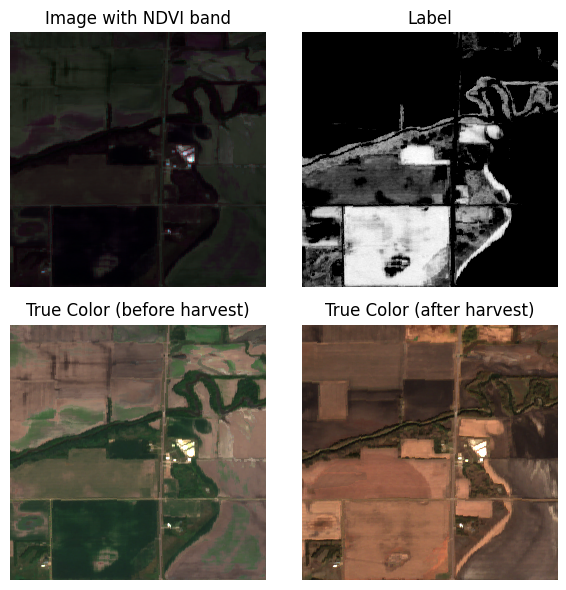

In [235]:
## Plot second item of batch
idx = 10
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

# Plot the "input" 
axes[0,0].imshow(  test[0][idx].permute((1,2,0))[:,:,:3]  )
axes[0,0].set_title("Image with NDVI band")
axes[0,0].axis('off')  # Turn off the axis

# Plot the "label" 
axes[0,1].imshow(test[1][idx], cmap="gray")
axes[0,1].set_title("Label")
axes[0,1].axis('off')  # Tu0,rn off the axis


r_s, r_e, c_s, c_e = test[2][idx]

# Plot the "RGB BEFORE" 
axes[1,0].imshow(before_rgb[ r_s: r_e, c_s:c_e, : ] )
axes[1,0].set_title("True Color (before harvest)")
axes[1,0].axis('off')  # Turn off the axis

# Plot the "RGB AFTER" 
axes[1,1].imshow(after_rgb[ r_s: r_e, c_s:c_e, :  ])
axes[1,1].set_title("True Color (after harvest)")
axes[1,1].axis('off')  # Turn off the axis

r_s, r_e, c_s, c_e = test[2][idx]

plt.tight_layout()
plt.show()

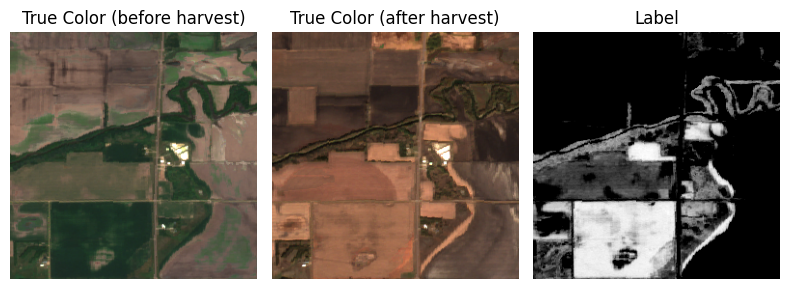

In [236]:
## Plot second item of batch
idx = 10
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

# Plot the "input" 
r_s, r_e, c_s, c_e = test[2][idx]

# Plot the "RGB BEFORE" 
axes[0].imshow(before_rgb[ r_s: r_e, c_s:c_e, : ] )
axes[0].set_title("True Color (before harvest)")
axes[0].axis('off')  # Turn off the axis

# Plot the "RGB AFTER" 
axes[1].imshow(after_rgb[ r_s: r_e, c_s:c_e, :  ])
axes[1].set_title("True Color (after harvest)")
axes[1].axis('off')  # Turn off the axis

# Plot the "label" 
axes[2].imshow(test[1][idx], cmap="gray")
axes[2].set_title("Label")
axes[2].axis('off')  # Tu0,rn off the axis

r_s, r_e, c_s, c_e = test[2][idx]

plt.tight_layout()
plt.show()

## Baseline Unet

In [333]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, out_channels, kernel_size=1),
            nn.Sigmoid()  # Final sigmoid activation

        )
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x1 = self.encoder(x)
        # print(x1.shape)
        x2 = self.middle(x1)
        # print(x2.shape)
        x3 = self.up(x2)
        # print(x3.shape)
        x4 = self.decoder(x3)
        # print(x4.shape)
        
        return x4

In [363]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # Concatenation doubles channels
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # Concatenation doubles channels
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Final output layer
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        # import pdb; pdb.set_trace()
        x1 = self.enc1(x)  # 64 channels
        x2 = self.pool1(x1)  # Downsample

        x3 = self.enc2(x2)  # 128 channels
        x4 = self.pool2(x3)  # Downsample

        # Middle
        x5 = self.middle(x4)  # 256 channels

        # Decoder
        x6 = self.up1(x5)  # Upsample to match x3
        x6 = torch.cat([x6, x3], dim=1)  # Concatenate encoder feature map
        x7 = self.dec1(x6)  # 128 channels

        x8 = self.up2(x7)  # Upsample to match x1
        x8 = torch.cat([x8, x1], dim=1)  # Concatenate encoder feature map
        x9 = self.dec2(x8)  # 64 channels

        # Final output
        output = self.final(x9)  # 1 output channel (probability map)
        return output

In [364]:
# Create an instance of the U-Net
in_channels = NUM_CHANNELS  # Number of channels in X
out_channels = 1  # Single-channel output for probability map
model = UNet(in_channels, out_channels)

In [365]:
from torchsummary import summary
summary(model, (4,256,256) )
# !pip install torchsummary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           2,368
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [366]:
# USING GPU
model.to(device)

UNet(
  (enc1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (middle): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (up1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec1): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (

In [367]:
# Define the loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [368]:
def dice_loss_2(pred, target, smooth=1):
    """
    Computes the Dice Loss.
    Args:
        pred (torch.Tensor): Predicted probability map (B, H, W) or (B, 1, H, W)
        target (torch.Tensor): Ground truth binary mask (B, H, W)
        smooth (float): Smoothing constant to avoid division by zero
    Returns:
        torch.Tensor: Dice loss value
    """
    pred, target = pred.contiguous(), target.contiguous()
    pred = torch.squeeze(pred, 1)

    mul = torch.mul(pred, target)
    mul = mul.sum(dim=[1,2])

    pred_sum = pred.sum(dim=[1,2])
    target_sum = target.sum(dim=[1,2])

    dice_losses = 1 -  (2 * mul + 1)/ ( pred_sum + target_sum + 1 )

    return torch.mean(dice_losses)

# DEFINE LOSS

In [370]:
# Weighted loss function combining Dice Loss and BCE Loss
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.bce = nn.BCELoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice = dice_loss_2(pred, target)

        return self.alpha * dice + self.beta * bce_loss, bce_loss, dice

# Create the loss function with weights
alpha = 1  # Weight for Dice Loss
beta = 0   # Weight for BCE Loss
criterion = CombinedLoss(alpha=alpha, beta=beta)

In [371]:
## Run a test output of Model .. 
test_output = model(test[0].float().to(device)) # Input be B, C , H, W , Output of shape : B, 1, H , W

In [372]:
def iou_score(predictions, targets, threshold=0.5):
    """
    Calculates the Intersection over Union (IoU) for predicted masks and ground truth masks.
    
    Args:
        predictions (torch.Tensor): Predicted masks (B, H, W) or (H, W), values in [0, 1].
        targets (torch.Tensor): Ground truth masks (B, H, W) or (H, W), binary {0, 1}.
        threshold (float): Threshold to binarize predictions.

    Returns:
        float: Mean IoU score.
    """
    predictions = (predictions > threshold).to("cpu").float().squeeze(1)
    targets = (targets > threshold).to("cpu").float()
    # across batch
    intersection = (predictions * targets).sum(dim=(1,2))
    union = (predictions + targets).clamp(0, 1).sum(dim=(1, 2))
    iou = (intersection / (union + 1e-6)).mean()
    return iou

In [373]:
count = 0
for X_batch, Y_batch, pos_batch in dataloader:
    count += 1
print(count, len(dataloader), len(val_dataloader))

12 12 22


In [375]:
num_epochs = 30  # Adjust based on your needs

# save_dir = './baseline_dice_loss_30_epochs/'
save_dir = './unet_dice_loss_hard_30_epochs/'

# save_dir = './unet_combined_loss_30_epochs/'

os.makedirs( save_dir, exist_ok=True )

best_model_path = os.path.join(save_dir, 'best_model.pth')
losses_file_path = os.path.join(save_dir, 'losses.json')

In [376]:
dice_losses_per_epochs = []
bce_losses_per_epochs = []
avg_losses_per_epochs = []
iou_per_epochs = []

val_dice_losses_per_epoch = []
val_bce_losses_per_epoch = []
val_avg_losses_per_epoch = []
val_iou_per_epochs = []

best_val_loss = float('inf')


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_bce_loss = 0.0
    running_dice_loss = 0.0
    running_iou = 0.0
    for X_batch, Y_batch, _pos in dataloader:
        X_batch, Y_batch = X_batch.float().to(device), Y_batch.float().to(device)  # Ensure data types
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss, bce_loss, dice = criterion(outputs.squeeze(), Y_batch)
        # loss = dice_loss_2(outputs.squeeze(), Y_batch) + 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_bce_loss += bce_loss.item()
        running_dice_loss += dice.item()
        running_iou += iou_score(outputs, Y_batch, threshold=0.25).item()
    # Todo : Add a validation dataloader like above ..

    # Print epoch statistics
    # print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

    dice_losses_per_epochs.append( running_loss / len(dataloader) )
    bce_losses_per_epochs.append( running_bce_loss / len(dataloader) )
    avg_losses_per_epochs.append( running_dice_loss / len(dataloader) )
    iou_per_epochs.append( running_iou / len(dataloader) )

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], ",
          f"Train Loss: {dice_losses_per_epochs[-1]:.4f}, ",
          f"BCE Train Loss: {bce_losses_per_epochs[-1]:.4f}, ",
          f"DICE Train Loss: {avg_losses_per_epochs[-1]:.4f}, ",
          f"IOU Train : {iou_per_epochs[-1]:.4f}, ",
          )
    
    ## Validation Part
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_bce_loss = 0.0
    val_running_dice_loss = 0.0
    val_running_iou = 0.0

    with torch.no_grad():
        for X_val, Y_val, _pos in val_dataloader:
            X_val, Y_val = X_val.float().to(device), Y_val.float().to(device)  # Ensure data types
            val_outputs = model(X_val)
            val_loss, val_bce_loss, val_dice = criterion(val_outputs.squeeze(), Y_val)
            val_running_loss += val_loss.item()
            val_running_bce_loss += val_bce_loss.item()
            val_running_dice_loss += val_dice.item()
            val_running_iou += iou_score( val_outputs, Y_val, threshold=0.25 ).item()

    # Store validation losses
    val_dice_losses_per_epoch.append(val_running_dice_loss / len(val_dataloader))
    val_bce_losses_per_epoch.append(val_running_bce_loss / len(val_dataloader))
    val_avg_losses_per_epoch.append(val_running_loss / len(val_dataloader))
    val_iou_per_epochs.append(val_running_iou / len(val_dataloader))

    # Save the best model
    if val_avg_losses_per_epoch[-1] < best_val_loss:
        best_val_loss = val_avg_losses_per_epoch[-1]
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch + 1} with validation loss {val_avg_losses_per_epoch[-1]:.4f}")


    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Val Net Loss:   {val_avg_losses_per_epoch[-1]:.4f}, "
          f"Val BCE Loss: {val_bce_losses_per_epoch[-1]:.4f}, ",
          f"Val DICE Loss: {val_dice_losses_per_epoch[-1]:.4f}",
          f"Val IOU Score: {val_iou_per_epochs[-1]:.4f}, "
          )

Epoch [1/30],  Train Loss: 0.6757,  BCE Train Loss: 0.7043,  DICE Train Loss: 0.6757,  IOU Train : 0.3991, 
Saved best model at epoch 1 with validation loss 0.6600
Epoch [1/30]
Val Net Loss:   0.6600, Val BCE Loss: 0.7193,  Val DICE Loss: 0.6600 Val IOU Score: 0.4194, 
Epoch [2/30],  Train Loss: 0.6649,  BCE Train Loss: 0.7660,  DICE Train Loss: 0.6649,  IOU Train : 0.3991, 
Saved best model at epoch 2 with validation loss 0.6338
Epoch [2/30]
Val Net Loss:   0.6338, Val BCE Loss: 0.8818,  Val DICE Loss: 0.6338 Val IOU Score: 0.4194, 
Epoch [3/30],  Train Loss: 0.6228,  BCE Train Loss: 3.9844,  DICE Train Loss: 0.6228,  IOU Train : 0.3991, 
Saved best model at epoch 3 with validation loss 0.5935
Epoch [3/30]
Val Net Loss:   0.5935, Val BCE Loss: 35.1756,  Val DICE Loss: 0.5935 Val IOU Score: 0.4194, 
Epoch [4/30],  Train Loss: 0.6091,  BCE Train Loss: 66.3251,  DICE Train Loss: 0.6091,  IOU Train : 0.3991, 
Saved best model at epoch 4 with validation loss 0.5935
Epoch [4/30]
Val Net Los

In [378]:
# Save losses to file
import json

losses = {
    "train_avg_losses": avg_losses_per_epochs,
    "train_bce_losses": bce_losses_per_epochs,
    "train_dice_losses": dice_losses_per_epochs,
    "train_iou_scores": iou_per_epochs,
    "val_avg_losses": val_avg_losses_per_epoch,
    "val_bce_losses": val_bce_losses_per_epoch,
    "val_dice_losses": val_dice_losses_per_epoch,
    "val_iou_scores" : val_iou_per_epochs, 
}

with open(losses_file_path, 'w') as f:
    json.dump(losses, f)

print(f"Saved losses to {losses_file_path}")


Saved losses to ./unet_dice_loss_hard_30_epochs/losses.json


In [ ]:
indices

[21,
 359,
 45,
 393,
 216,
 514,
 243,
 218,
 391,
 237,
 204,
 312,
 136,
 446,
 215,
 298,
 488,
 14,
 467,
 23,
 138,
 486,
 60,
 464,
 249,
 247,
 316,
 412,
 167,
 366,
 410,
 96,
 487,
 387,
 180,
 63,
 47,
 209,
 442,
 28,
 40,
 389,
 161,
 56,
 111,
 365,
 382,
 58,
 252,
 176,
 407,
 87,
 384,
 122,
 508,
 36,
 224,
 482,
 80,
 44,
 178,
 517,
 275,
 12,
 183,
 193,
 358,
 261,
 110,
 439,
 300,
 121,
 282,
 186,
 438,
 356,
 188,
 269,
 93,
 435,
 173,
 295,
 397,
 390,
 200,
 256,
 379,
 16,
 39,
 273,
 3,
 203,
 147,
 434,
 61,
 27,
 102,
 398,
 98,
 339,
 112,
 86,
 450,
 409,
 55,
 250,
 505,
 431,
 119,
 443,
 377,
 33,
 320,
 485,
 242,
 230,
 82,
 222,
 125,
 194,
 436,
 126,
 134,
 246,
 472,
 190,
 433,
 17,
 334,
 395,
 317,
 221,
 95,
 127,
 205,
 177,
 287,
 78,
 184,
 406,
 394,
 345,
 154,
 469,
 130,
 293,
 383,
 283,
 424,
 403,
 164,
 94,
 32,
 53,
 375,
 24,
 337,
 19,
 259,
 90,
 255,
 210,
 181,
 277,
 13,
 6,
 79,
 493,
 133,
 182,
 235,
 254,
 347,
 452

In [ ]:
i

## Baseline Loss

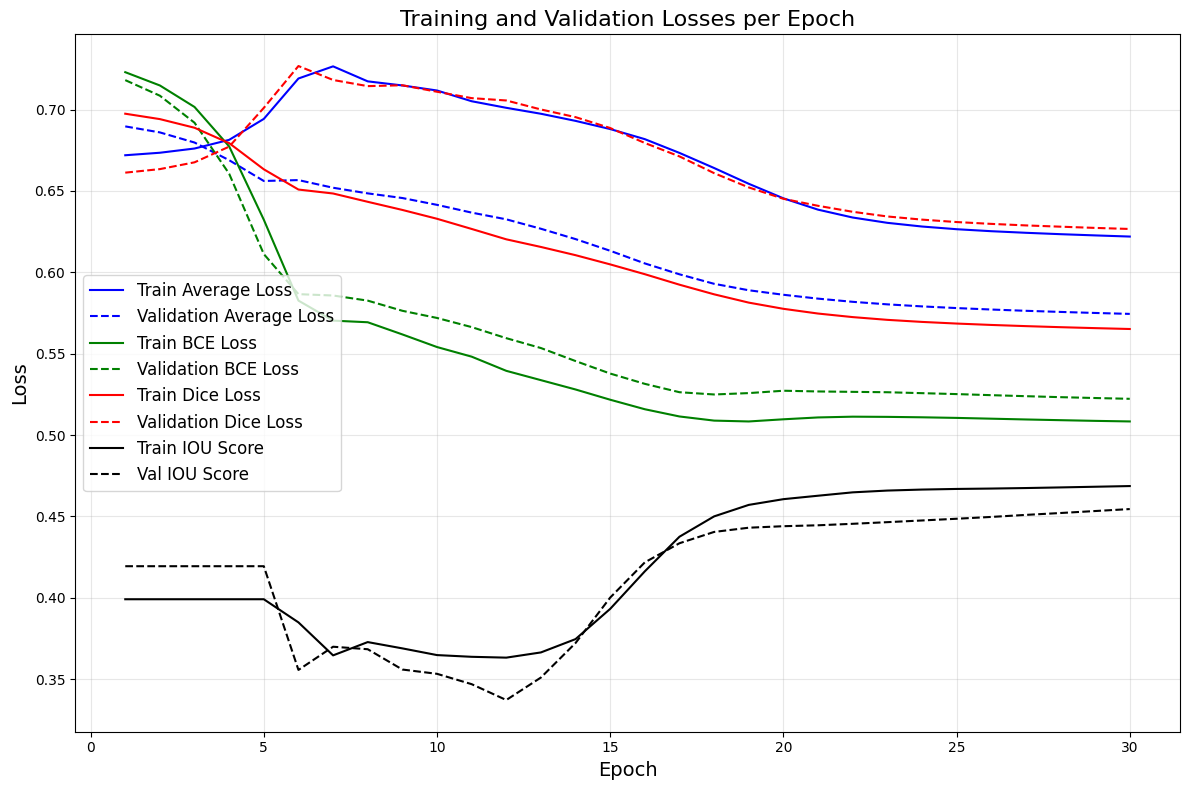

In [318]:
# Plotting
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(12, 8))
plt.plot( list(range(1, len(avg_losses_per_epochs)+ 1)) , avg_losses_per_epochs, label="Train Average Loss", color="blue", linestyle="-")
plt.plot( list(range(1, len(val_avg_losses_per_epoch)+ 1)) , val_avg_losses_per_epoch, label="Validation Average Loss", color="blue", linestyle="--")

plt.plot( list(range(1, len(bce_losses_per_epochs)+ 1)), bce_losses_per_epochs, label="Train BCE Loss", color="green", linestyle="-")
plt.plot( list(range(1, len(val_bce_losses_per_epoch)+ 1)), val_bce_losses_per_epoch, label="Validation BCE Loss", color="green", linestyle="--")

plt.plot( list(range(1, len(dice_losses_per_epochs)+ 1)), dice_losses_per_epochs, label="Train Dice Loss", color="red", linestyle="-")
plt.plot( list(range(1, len(val_dice_losses_per_epoch)+ 1)), val_dice_losses_per_epoch, label="Validation Dice Loss", color="red", linestyle="--")

plt.plot( list(range(1, len(iou_per_epochs)+ 1)), iou_per_epochs, label="Train IOU Score", color="black", linestyle="-")
plt.plot( list(range(1, len(val_iou_per_epochs)+ 1)), val_iou_per_epochs, label="Val IOU Score", color="black", linestyle="--")


# Adding labels, legend, and grid
plt.title("Training and Validation Losses per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

## BCE LOSS

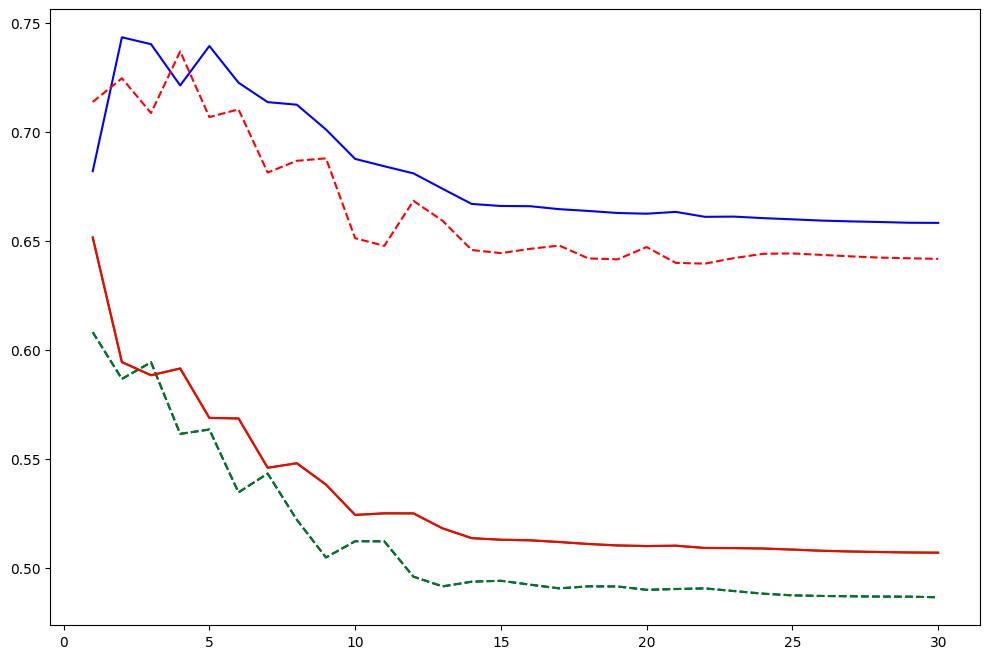

In [ ]:
# Plotting
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(12, 8))
plt.plot( list(range(1, len(avg_losses_per_epochs)+ 1)) , avg_losses_per_epochs, label="Train Average Loss", color="blue", linestyle="-")
plt.plot( list(range(1, len(val_avg_losses_per_epoch)+ 1)) , val_avg_losses_per_epoch, label="Validation Average Loss", color="blue", linestyle="--")
plt.plot( list(range(1, len(bce_losses_per_epochs)+ 1)), bce_losses_per_epochs, label="Train BCE Loss", color="green", linestyle="-")
plt.plot( list(range(1, len(val_bce_losses_per_epoch)+ 1)), val_bce_losses_per_epoch, label="Validation BCE Loss", color="green", linestyle="--")
plt.plot( list(range(1, len(dice_losses_per_epochs)+ 1)), dice_losses_per_epochs, label="Train Dice Loss", color="red", linestyle="-")
plt.plot( list(range(1, len(val_dice_losses_per_epoch)+ 1)), val_dice_losses_per_epoch, label="Validation Dice Loss", color="red", linestyle="--")

# Adding labels, legend, and grid
plt.title("Training and Validation Losses per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()




## COMBINED LOSS

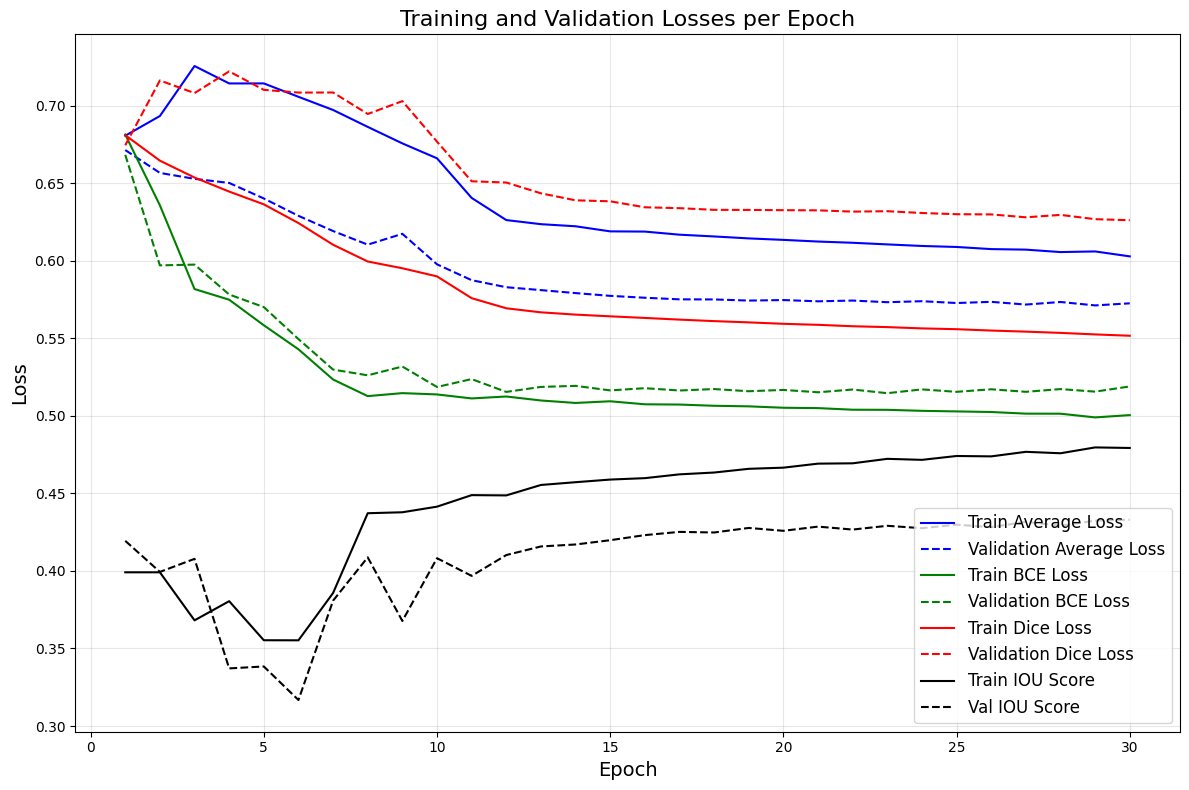

In [279]:
# Plotting
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(12, 8))
plt.plot( list(range(1, len(avg_losses_per_epochs)+ 1)) , avg_losses_per_epochs, label="Train Average Loss", color="blue", linestyle="-")
plt.plot( list(range(1, len(val_avg_losses_per_epoch)+ 1)) , val_avg_losses_per_epoch, label="Validation Average Loss", color="blue", linestyle="--")
plt.plot( list(range(1, len(bce_losses_per_epochs)+ 1)), bce_losses_per_epochs, label="Train BCE Loss", color="green", linestyle="-")
plt.plot( list(range(1, len(val_bce_losses_per_epoch)+ 1)), val_bce_losses_per_epoch, label="Validation BCE Loss", color="green", linestyle="--")
plt.plot( list(range(1, len(dice_losses_per_epochs)+ 1)), dice_losses_per_epochs, label="Train Dice Loss", color="red", linestyle="-")
plt.plot( list(range(1, len(val_dice_losses_per_epoch)+ 1)), val_dice_losses_per_epoch, label="Validation Dice Loss", color="red", linestyle="--")

plt.plot( list(range(1, len(iou_per_epochs)+ 1)), iou_per_epochs, label="Train IOU Score", color="black", linestyle="-")
plt.plot( list(range(1, len(val_iou_per_epochs)+ 1)), val_iou_per_epochs, label="Val IOU Score", color="black", linestyle="--")

# Adding labels, legend, and grid
plt.title("Training and Validation Losses per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()



In [203]:
best_model_path

'./unet_dice_loss_30_epochs/best_model.pth'

### INFERENCE
- Load model. Test Performance on different images.

In [ ]:
import torch

# model_path = './unet_dice_loss_30_epochs/best_model.pth'
# losses = './unet_dice_loss_30_epochs/losses.json'

model_path = './unet_combined_loss_30_epochs/best_model.pth'
losses = './unet_combined_loss_30_epochs/losses.json'

# model_path = './unet_bce_loss_30_epochs/best_model.pth'
# losses = './unet_bce_loss_30_epochs/losses.json'
# 1. Instantiate your model

# 2. Load the saved state dictionary
model.load_state_dict(torch.load( model_path ))

# 3. Set the model to eval mode (if you are making predictions)
model.eval() 

/var/folders/5q/d5sngbr11bj5s27jzhrdww2r0000gn/T/ipykernel_58213/2533149810.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load( model_path

UNet(
  (enc1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (middle): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (up1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec1): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (

In [272]:
sum = 0
for X_batch, Y_batch, pos_batch in val_dataloader:
    sum += len(X_batch)
# print(count, len(dataloader), len(val_dataloader))

In [267]:
X_batch.shape, Y_batch.shape, pos_batch.shape

(torch.Size([12, 4, 256, 256]),
 torch.Size([12, 256, 256]),
 torch.Size([12, 4]))

In [286]:
## Now look at how model is performing
idx = 10
with torch.no_grad():  
    ## Run a test output of Model .. 
    test_output = model(X_batch.float().to(device))

In [291]:
test_output.shape

torch.Size([12, 1, 256, 256])

In [292]:
actual_image = X_batch[idx].permute((1,2,0) ) # First example of test-batch
pred_croparea = test_output.squeeze()[idx]

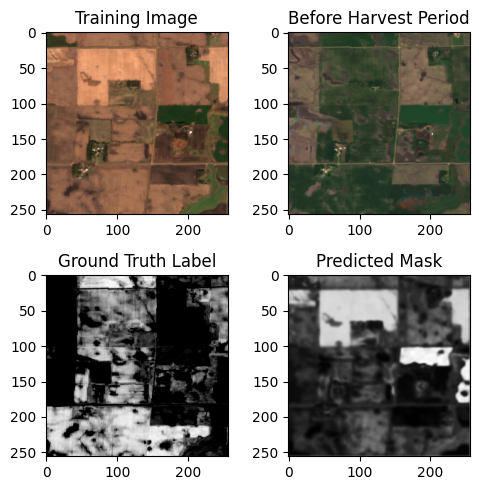

In [293]:
# Function to plot input image and prediction side by side
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

# Plot the input image
# ax[0,0].axis('off')


# Plot ACTUAL RGB
r_s, r_e, c_s, c_e = pos_batch[idx]

if False:
    ax[0,0].imshow(before_rgb[ r_s:r_e, c_s: c_e, :  ] )
    ax[0,0].set_title("Training Image")

    ax[0,1].imshow( after_rgb[ r_s:r_e, c_s: c_e, :  ] )  
    ax[0,1].set_title("After Harvest (for reference)")
else:
    ax[0,0].imshow(after_rgb[ r_s:r_e, c_s: c_e, :  ] )
    ax[0,0].set_title("Training Image")

    ax[0,1].imshow( before_rgb[ r_s:r_e, c_s: c_e, :  ] )  
    ax[0,1].set_title("Before Harvest Period")


# ax[1,1].axis('off')




# Plot the ground truth label
ax[1,0].imshow(Y_batch[idx], cmap='gray')
ax[1,0].set_title("Ground Truth Label")
# ax[0,1].axis('off')

# Plot the prediction
ax[1,1].imshow(pred_croparea.to('cpu'), cmap='gray')
ax[1,1].set_title("Predicted Mask")
# ax[1,0].axis('off')


plt.tight_layout()
plt.show()


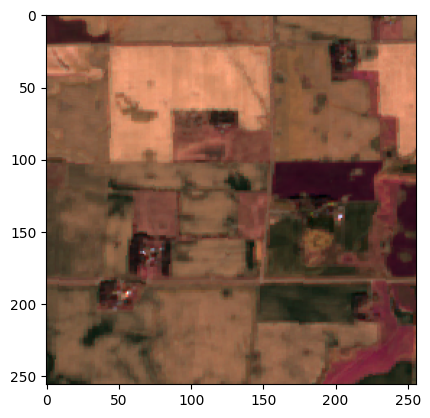

In [290]:
plt.imshow(actual_image[:,:,:3])

In [284]:
actual_image.shape

torch.Size([256, 256, 4])

In [1]:
import numpy as np

ModuleNotFoundError: No module named 'numpy'

In [ ]:
cl

python not found
